In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import inv, hankel
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

sys.path.append('./../../tensor-dynamic-univariate-ts-pytorch/')
from tensordynamicmodel.visuals import plot_phase_trajectory, delay_embedding_matrix
from tensordynamicmodel.utils import delay_embedding_matrix, diag_mean, prepare_time_series, lorenz

In [2]:
# plt.rcParams['font.family'] = 'DejaVu Serif'
# plt.rcParams.update({"text.usetex": False})

In [3]:
def moving_average_simple(data, window_size):
    """
    Простая реализация скользящего среднего
    """
    moving_avg = []
    for i in range(len(data)):
        if i < window_size - 1:
            # Для первых элементов недостаточно данных
            moving_avg.append(np.nan)
        else:
            # Вычисляем среднее для окна
            window = data[i - window_size + 1:i + 1]
            moving_avg.append(np.mean(window))
    return np.array(moving_avg)
    
def make_ts(person, activity):
    pdf_data_all = pd.read_csv(f'./../data/A_DeviceMotion_data/{activity}/sub_{person}.csv').reset_index(drop=True)
    data_list = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    data_list_short = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
    pdf_data_all = pdf_data_all[data_list_short]
    xyz = pdf_data_all[data_list_short].to_numpy()
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    return (x**2 + y**2 + z**2)**0.5

def acc_ts_alignment(x, trashhold = 2):
    x = (x - x.mean())/(x.var()**.5)
    i_peak, _ = find_peaks(x)
    i_min_peak = [i for i in i_peak if x[i] >= trashhold]
    return i_min_peak[0]


In [4]:
# def prepare_ts(person, activity, global_start_point, global_end_point, person_start_point_map_500):
#     ts = make_ts(person, 'wlk_15')[global_start_point+person_start_point_map_500[person]:global_end_point]
#     # ts = moving_average_simple(ts, 20)[20:]
#     return ts


def prepare_ts(person, activity, global_start_point, global_end_point, person_start_point_map_500):
    ts = make_ts(person, 'wlk_15')[global_start_point+person_start_point_map_500[person]:global_end_point]
    ts = (ts - ts.mean())/ts.var()**0.5
    # ts = moving_average_simple(ts, 20)[20:]
    return ts

In [5]:
global_start_point = 500
global_end_point = None
person_start_point_map_500 = {
    1: 5-1,
    2: 6,
    3: 9,
    4: 45,
    5: 13-4,
    6: 16,
    7: 63,
    8: 68,
    9: 69,
    10: 47,
    11: 29,
    12: 40,
    13: 44-5,
    14: 13,
    15: 49,
    16: 3-1,
    17: 13,
    18: 8,
    19: 26+10,
    20: 40,
    21: 46,
    22: 16,
    23: 47-8,
    24: 34-6
}

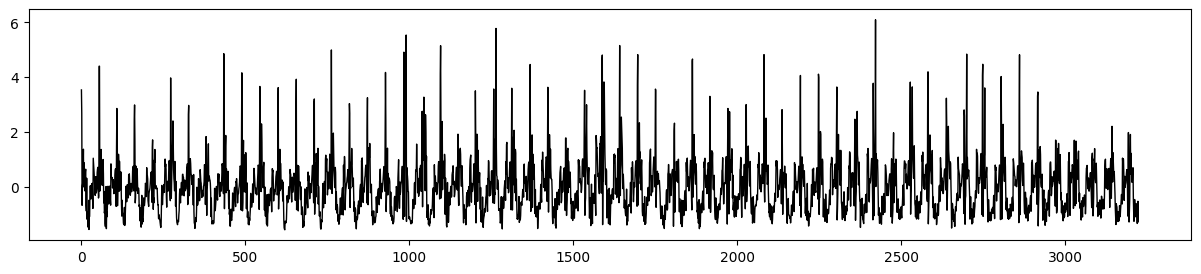

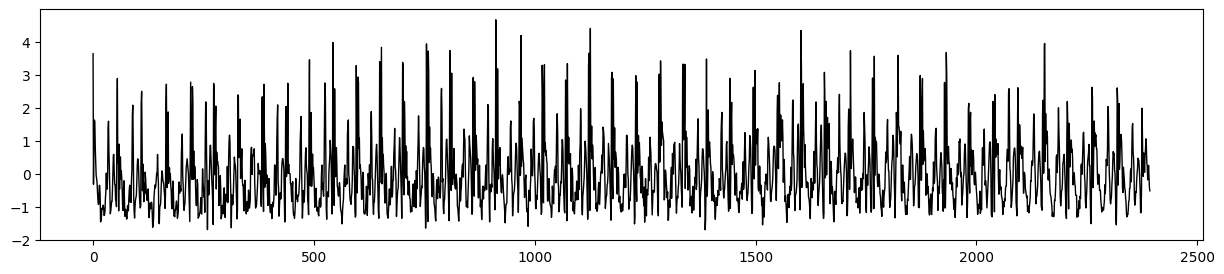

In [6]:
ts_1 = prepare_ts(4, 'wlk_7', global_start_point, global_end_point, person_start_point_map_500)
ts_2 = prepare_ts(7, 'wlk_7', global_start_point, global_end_point, person_start_point_map_500)

plt.figure(figsize=(15,3))
plt.plot(ts_1[:], color = 'black', ls = '-', lw = 1)
plt.show()

plt.figure(figsize=(15,3))
plt.plot(ts_2[:], color = 'black', ls = '-', lw = 1)
plt.show()

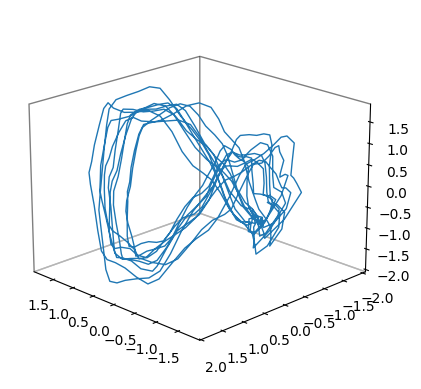

In [7]:
s = PCA(3).fit_transform(delay_embedding_matrix(ts_1, 50))
s =(s-s[:500,:].mean(axis=0))/s[:500,:].var(axis=0)**0.5
ax = plot_phase_trajectory(s[:500,:], rotation=(0, 0, 0))

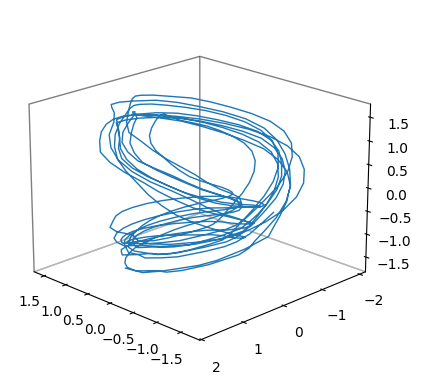

In [8]:
s = PCA(3).fit_transform(delay_embedding_matrix(ts_2, 50))
s =(s-s.mean(axis=0))/s.var(axis=0)**0.5
ax = plot_phase_trajectory(s[:500,:], rotation=(0, 0, 0))

## Phase space reconstruction

In [9]:
from numpy.linalg import inv

In [10]:
class UnionDynamicRegression():
    
    def __init__(self, nlags, p):
        self.nlags = nlags
        self.p = p
        
    def _delay_embedding_matrix(self, s, nlags, fit_intercept=False):
        N = len(s)
        delay_embedding_matrix = hankel(s[:N - nlags + 1], s[N - nlags: N])
        if fit_intercept:
            delay_embedding_matrix = np.hstack((np.ones((delay_embedding_matrix.shape[0], 1)), delay_embedding_matrix))
        return delay_embedding_matrix

    def _make_space(self, list_ts, nlags, X_theta):
        union_X = np.array([])
        for i, ts in enumerate(list_ts):
            
            X = self._delay_embedding_matrix(ts, nlags)
            X = np.concatenate((X,np.ones((X.shape[0],X_theta.shape[1]))*X_theta[i,:]), axis=1)
            if len(union_X) != 0:
                union_X = np.append(union_X, X, axis=0)
            else:
                union_X = X
        return union_X
        

    def fit(self, list_ts, X_theta):
        self.X_theta = np.array(X_theta)
        union_X = self._make_space(list_ts, nlags, X_theta)
        self.model = PCA(self.p).fit(union_X)
        return self

    def transform(self, ts, x_theta):
        X = self._delay_embedding_matrix(ts, nlags)
        X = np.concatenate((X,np.ones((X.shape[0], len(x_theta)))*x_theta), axis=1)
        S = self.model.transform(X)
        return S
    def inverse_transform(self, S, x_theta):
        union_X = self.model.inverse_transform(S)
        X = union_X[:,:-len(x_theta)]
        return X

In [11]:
import numpy as np
from scipy.linalg import hankel, inv
from sklearn.decomposition import PCA
from typing import List, Tuple, Dict, Optional, Union, Any


class JacobianDynamicRegression:
    """
    A class for dynamic regression using Jacobian-based subspace transformations.
    
    This method models time series data by learning dynamic systems in embedded
    subspaces and using Jacobian matrices to handle variations in system parameters.
    
    Parameters
    ----------
    nlags : int
        Number of time lags for delay embedding.
    p : int
        Dimension of the principal component subspace.
    
    Attributes
    ----------
    nlags : int
        Number of time lags for delay embedding.
    p : int
        Dimension of the principal component subspace.
    min_lenth : float
        Minimum length across all time series after delay embedding.
    list_S : List[np.ndarray]
        List of subspace representations for each time series.
    list_model : List[PCA]
        List of PCA models for each time series.
    J : Optional[np.ndarray]
        Jacobian matrix capturing parameter variations.
    n_theta : Optional[int]
        Number of parameter vectors.
    dim_theta : Optional[int]
        Dimension of parameter space.
    X_theta : Optional[np.ndarray]
        Parameter matrix.
    """
    
    def __init__(self, nlags: int, p: int) -> None:
        self.nlags = nlags
        self.p = p
        self.min_lenth = np.inf
        self.list_S: List[np.ndarray] = []
        self.list_model: List[PCA] = []
        self.J: Optional[np.ndarray] = None
        self.n_theta: Optional[int] = None
        self.dim_theta: Optional[int] = None
        self.X_theta: Optional[np.ndarray] = None
        
    def _delay_embedding_matrix(self, s: np.ndarray, nlags: int, 
                              fit_intercept: bool = False) -> np.ndarray:
        """
        Create a matrix with delay embeddings using Hankel matrix construction.
        
        Parameters
        ----------
        s : np.ndarray
            The time series data as a 1D array.
        nlags : int
            Size of time lags for embedding.
        fit_intercept : bool, default=False
            Whether to add an intercept column to the matrix.
            
        Returns
        -------
        delay_embedding_matrix : np.ndarray of shape (len(s) - nlags + 1, nlags)
            Matrix with delay embeddings. If fit_intercept is True, shape is
            (len(s) - nlags + 1, nlags + 1).
            
        Examples
        --------
        >>> s = np.array([1, 2, 3, 4, 5])
        >>> matrix = self._delay_embedding_matrix(s, 3)
        >>> matrix.shape
        (3, 3)
        """
        N = len(s)
        delay_embedding_matrix = hankel(s[:N - nlags + 1], s[N - nlags: N])
        
        if fit_intercept:
            delay_embedding_matrix = np.hstack((
                np.ones((delay_embedding_matrix.shape[0], 1)), 
                delay_embedding_matrix
            ))
            
        return delay_embedding_matrix

    def _make_subspace(self, list_ts: List[np.ndarray], nlags: int
                      ) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        Create subspace representations for all time series using PCA.
        
        Parameters
        ----------
        list_ts : List[np.ndarray]
            List of time series data arrays.
        nlags : int
            Number of lags for delay embedding.
            
        Returns
        -------
        list_S : List[np.ndarray]
            List of subspace representations (PCA transformed data).
        list_X : List[np.ndarray] 
            List of delay-embedded matrices for each time series.
        """
        list_S: List[np.ndarray] = []
        list_X: List[np.ndarray] = []
        
        for ts in list_ts:
            X = self._delay_embedding_matrix(ts, nlags)
            list_X.append(X)
            cur_min_lenth = X.shape[0]
            
            # Update minimum length across all time series
            if cur_min_lenth < self.min_lenth:
                self.min_lenth = cur_min_lenth
                
            # Fit PCA and transform to subspace
            model = PCA(self.p).fit(X)
            S = model.transform(X)

            self.list_model.append(model)
            list_S.append(S)
            
        # Truncate all series to minimum length
        list_S = [S[:self.min_lenth, :] for S in list_S]
        list_X = [X[:self.min_lenth, :] for X in list_X]
        
        return list_S, list_X
        
    def _calculate_jacobian(self, list_S: List[np.ndarray], 
                          list_X: List[np.ndarray], 
                          X_theta: np.ndarray) -> np.ndarray:
        """
        Calculate the Jacobian matrix capturing system parameter variations.
        
        Parameters
        ----------
        list_S : List[np.ndarray]
            List of subspace representations.
        list_X : List[np.ndarray]
            List of delay-embedded matrices.
        X_theta : np.ndarray
            Parameter matrix of shape (n_theta, dim_theta).
            
        Returns
        -------
        J : np.ndarray
            Jacobian matrix capturing parameter variations.
        """
        self.n_theta = X_theta.shape[0]
        self.dim_theta = X_theta.shape[1]
        
        # Create all pairs of different time series indices
        ts_index = [(i, j) for i in range(self.n_theta) 
                   for j in range(self.n_theta) if i != j]
        
        list_delta_S: List[np.ndarray] = []
        list_theta_times_S: List[np.ndarray] = []
        
        for i, j in ts_index:
            # Transform series j using model i
            tilda_S = self.list_model[i].transform(list_X[j])
            delta_S = list_S[j] - tilda_S
            list_delta_S.append(delta_S)
            
            # Parameter difference
            delta_theta = (X_theta[j, :] - X_theta[i, :])
            theta_times_S = np.outer(tilda_S, delta_theta)
            theta_times_S = theta_times_S.reshape((self.min_lenth, -1))
            list_theta_times_S.append(theta_times_S)

        # Concatenate all pairs
        matrix_delta_S = np.concatenate(list_delta_S, axis=0)
        matrix_theta_times_S = np.concatenate(list_theta_times_S, axis=0)
        
        # Solve linear system for Jacobian: matrix_theta_times_S * J ≈ matrix_delta_S
        self.J = inv(matrix_theta_times_S.T @ matrix_theta_times_S) @ \
                matrix_theta_times_S.T @ matrix_delta_S
        
        return self.J

    def _find_nearest_dynamic_system(self, x_theta: np.ndarray
                                   ) -> Tuple[int, np.ndarray]:
        """
        Find the nearest dynamic system in parameter space.
        
        Parameters
        ----------
        x_theta : np.ndarray
            Parameter vector of shape (dim_theta,).
            
        Returns
        -------
        i_nn : int
            Index of nearest neighbor in parameter space.
        x_theta_nn : np.ndarray
            Nearest neighbor parameter vector.
            
        Raises
        ------
        ValueError
            If model has not been fitted (X_theta is None).
        """
        if self.X_theta is None:
            raise ValueError("Model must be fitted before calling this method.")
            
        distances = np.sum((self.X_theta - x_theta)**2, axis=1)**0.5
        i_nn = np.argmin(distances)
        x_theta_nn = self.X_theta[i_nn, :]
        
        return i_nn, x_theta_nn

    def params(self) -> Dict[str, Any]:
        """
        Get model parameters.
        
        Returns
        -------
        params : Dict[str, Any]
            Dictionary containing:
            - 'phase_space_model': List of PCA models
            - 'jacobian': Jacobian matrix
            - 'nlags': Number of lags
            - 'p': Subspace dimension
        """
        return {
            'phase_space_model': self.list_model,
            'jacobian': self.J,
            'nlags': self.nlags,
            'p': self.p
        }

    def fit(self, list_ts: List[np.ndarray], X_theta: np.ndarray) -> 'JacobianDynamicRegression':
        """
        Fit the model to time series data with associated parameters.
        
        Parameters
        ----------
        list_ts : List[np.ndarray]
            List of time series data arrays.
        X_theta : Union[List[np.ndarray], np.ndarray]
            Parameter matrix or list of parameter vectors.
            
        Returns
        -------
        self : JacobianDynamicRegression
            Fitted model instance.
            
        Raises
        ------
        ValueError
            If number of time series doesn't match number of parameter vectors.
        """
        self.X_theta = np.array(X_theta)
        
        if len(list_ts) != self.X_theta.shape[0]:
            raise ValueError(
                f"Number of time series ({len(list_ts)}) must match "
                f"number of parameter vectors ({self.X_theta.shape[0]})"
            )
        
        list_S, list_X = self._make_subspace(list_ts, self.nlags)
        J = self._calculate_jacobian(list_S, list_X, self.X_theta)
        
        return self

    def transform(self, ts: np.ndarray, x_theta: np.ndarray, 
                 flg_near_model: bool = False) -> np.ndarray:
        """
        Transform a time series to subspace representation.
        
        Parameters
        ----------
        ts : np.ndarray
            Time series data to transform.
        x_theta : np.ndarray
            Parameter vector associated with the time series.
        flg_near_model : bool, default=False
            If True, use nearest model without Jacobian correction.
            If False, apply Jacobian correction.
            
        Returns
        -------
        S : np.ndarray
            Subspace representation of the time series.
        """
        i_nn, x_theta_nn = self._find_nearest_dynamic_system(x_theta)
        X_ts = self._delay_embedding_matrix(ts, self.nlags)
        S = self.list_model[i_nn].transform(X_ts)
        
        if flg_near_model:
            return S
        else:
            # Apply Jacobian correction
            delta_theta = x_theta - x_theta_nn
            theta_times_S = np.outer(S, delta_theta)
            theta_times_S = theta_times_S.reshape((S.shape[0], -1))
            S = S + theta_times_S @ self.J
            return S
            
    def inverse_transform(self, S: np.ndarray, x_theta: np.ndarray,
                         flg_near_model: bool = False) -> np.ndarray:
        """
        Transform from subspace representation back to time series.
        
        Parameters
        ----------
        S : np.ndarray
            Subspace representation to transform back.
        x_theta : np.ndarray
            Parameter vector associated with the subspace representation.
        flg_near_model : bool, default=False
            If True, use nearest model without Jacobian correction.
            If False, apply inverse Jacobian correction.
            
        Returns
        -------
        X : np.ndarray
            Reconstructed time series in original space.
        """
        i_nn, x_theta_nn = self._find_nearest_dynamic_system(x_theta)
        
        if flg_near_model:
            X = self.list_model[i_nn].inverse_transform(S)
            return X
        else:
            # Apply inverse Jacobian correction
            delta_theta = x_theta - x_theta_nn
            J = self.J.reshape((self.p, self.dim_theta, self.p))
            mJ = np.identity(self.p) + np.einsum('ijk,j->ik', J, delta_theta)
            S_corrected = S @ inv(mJ)
            X = self.list_model[i_nn].inverse_transform(S_corrected)
            return X

In [12]:
global_start_point = 500
global_end_point = None
person_start_point_map_500 = {
    1: 5-1,
    2: 6,
    3: 9,
    4: 45,
    5: 13-4,
    6: 16,
    7: 63,
    8: 68,
    9: 69,
    10: 47,
    11: 29,
    12: 40,
    13: 44-5,
    14: 13,
    15: 49,
    16: 3-1,
    17: 13,
    18: 8,
    19: 26+10,
    20: 40,
    21: 46,
    22: 16,
    23: 47-8,
    24: 34-6
}

# Точность на новых временных рядах

In [13]:
list_ts = []
for person in range(1, 25):
    print(person, end=' ')
    ts = make_ts(person, 'wlk_7')[global_start_point+person_start_point_map_500[person]:global_end_point]
    ts = (ts - ts.mean())/(ts.var()**.5)
    list_ts.append(ts)
    

theta_all =  pd.read_csv('./../data/A_DeviceMotion_data/data_subjects_info.csv').drop(columns=['code'])
theta_all = ((theta_all - theta_all.mean())/(theta_all.var()**.5)).to_numpy()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [14]:
def make_experimnt_2(n_ts_train, nlags, p):
    list_ts_train = list_ts[:n_ts_train]
    theta_all_train = theta_all[:n_ts_train,:]
    
    theta_all_test = theta_all[n_ts_train:,:]
    list_ts_test = list_ts[n_ts_train:]
    
    model = JacobianDynamicRegression(nlags,p).fit(list_ts_train, theta_all_train)
    r2_mean = []
    for ts_i, theta_i in zip(list_ts_test, theta_all_test):

        
        X_true = delay_embedding_matrix(ts_i, nlags)
        
        tmp_model = PCA(model.params()['p']).fit(X_true)
        
        S_true = tmp_model.transform(delay_embedding_matrix(ts_i, nlags))
        S_near =  model.transform(ts_i, theta_i, flg_near_model=True)
        S_suggest = model.transform(ts_i, theta_i)
        
        # S_true = (S_true-S_true.mean(axis=0))/S_true.var(axis=0)**0.5
        # S_near = (S_near-S_near.mean(axis=0))/S_near.var(axis=0)**0.5
        # S_suggest = (S_suggest-S_suggest.mean(axis=0))/S_suggest.var(axis=0)**0.5
        
        X_rec_1 = tmp_model.inverse_transform(S_true)
        X_rec_2 = model.inverse_transform(S_suggest, theta_i, flg_near_model=True)
        X_rec_3 = model.inverse_transform(S_suggest, theta_i)

        a_1 = round(r2_score(X_true, X_rec_1), 4)
        a_2 = round(r2_score(X_true, X_rec_2), 4)
        a_3 = round(r2_score(X_true, X_rec_3), 4)

        r2_mean.append(a_3-a_2)
    return np.mean(r2_mean)

In [16]:
# for p in range(3,6):
#     for nlags in range(5,55,5):
#         r2_mean_lags = []
#         for n_ts_train in range(5,21):
#             r2_mean_lags.append(make_experimnt_2(n_ts_train, nlags, p))
#         r2_mean_lags = np.mean(r2_mean_lags)
#         print(f'p {p} nlags {nlags} mean r2 {round(r2_mean_lags,4)}')
#         # print(f'Ts count in train {n_ts_train} mean r2 {round(r2_mean,4)}')

In [17]:
n_ts_train = 10
p = 6
nlags = 35

list_ts_train = list_ts[:n_ts_train]
theta_all_train = theta_all[:n_ts_train,:]

theta_all_test = theta_all[n_ts_train:,:]
list_ts_test = list_ts[n_ts_train:]

for p in range(3,8):

    
    union_model = UnionDynamicRegression(nlags,p).fit(list_ts_train, theta_all_train)
    model = JacobianDynamicRegression(nlags,p).fit(list_ts_train, theta_all_train)
    
    list_r_init = []
    list_r_nn = []
    list_r_union = []
    list_r_suggest = []
    for ts_i, theta_i in zip(list_ts_test, theta_all_test):
    
        
        X_true = delay_embedding_matrix(ts_i, nlags)
        
        tmp_model = PCA(model.params()['p']).fit(X_true)
        
        S_true = tmp_model.transform(delay_embedding_matrix(ts_i, nlags))
        S_near =  model.transform(ts_i, theta_i, flg_near_model=True)
        S_union =  union_model.transform(ts_i, theta_i)
        S_suggest = model.transform(ts_i, theta_i)
        
        X_rec_1 = tmp_model.inverse_transform(S_true)
        X_rec_2 = model.inverse_transform(S_suggest, theta_i, flg_near_model=True)
        X_rec_3 = union_model.inverse_transform(S_union, theta_i)
        X_rec_4 = model.inverse_transform(S_suggest, theta_i)
    
        r_init = r2_score(X_true, X_rec_1)
        r_nn = r2_score(X_true, X_rec_2)
        r_union = r2_score(X_true, X_rec_3)
        r_suggest = r2_score(X_true, X_rec_4)
    
        list_r_init.append(r_init)
        list_r_nn.append(r_nn)
        list_r_union.append(r_union)
        list_r_suggest.append(r_suggest)
    
    r_init = np.array(list_r_init).mean().round(3)
    r_nn = np.array(list_r_nn).mean().round(3)
    r_union = np.array(list_r_union).mean().round(3)
    r_suggest = np.array(list_r_suggest).mean().round(3)
    print(r_init, r_nn, r_union, r_suggest)

0.392 0.307 0.28 0.338
0.466 0.318 0.354 0.407
0.518 0.351 0.428 0.45
0.565 0.379 0.467 0.488
0.608 0.409 0.505 0.521


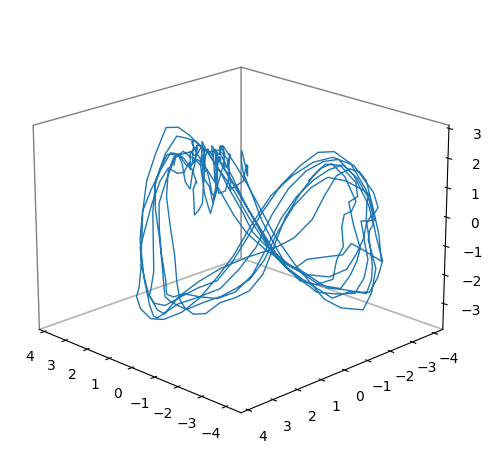

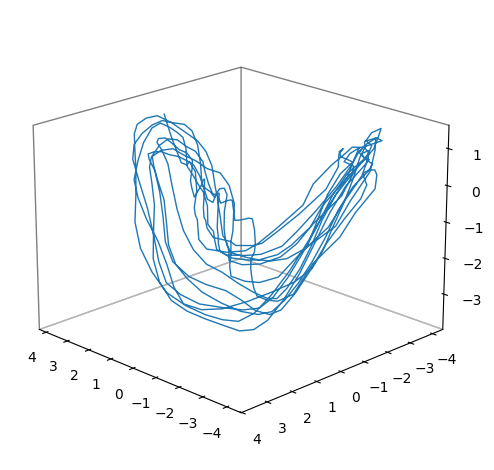

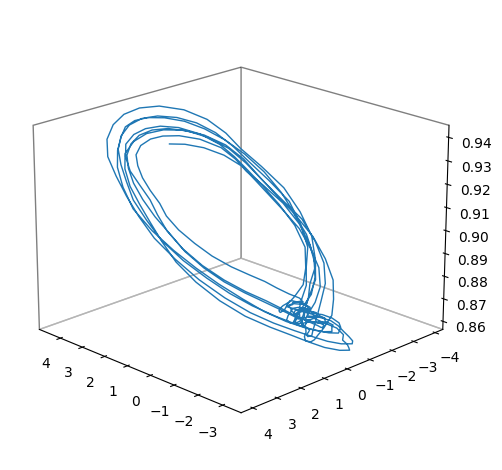

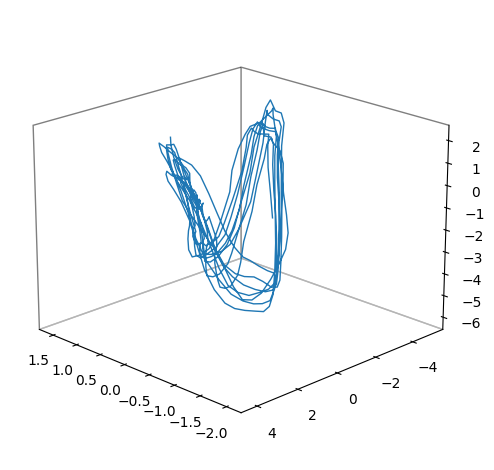

In [18]:
n_ts_train = 5
p = 3
nlags = 35

list_ts_train = list_ts[:n_ts_train]
theta_all_train = theta_all[:n_ts_train,:]

theta_all_test = theta_all[n_ts_train:,:]
list_ts_test = list_ts[n_ts_train:]

union_model = UnionDynamicRegression(nlags,p).fit(list_ts_train, theta_all_train)
model = JacobianDynamicRegression(nlags,p).fit(list_ts_train, theta_all_train)

# i = 6
i = 8
ts_i, theta_i = list_ts_test[i], theta_all_test[i]

X_true = delay_embedding_matrix(ts_i, nlags)

tmp_model = PCA(model.params()['p']).fit(X_true)

S_true = tmp_model.transform(delay_embedding_matrix(ts_i, nlags))
S_near =  model.transform(ts_i, theta_i, flg_near_model=True)
S_union =  union_model.transform(ts_i, theta_i)
S_suggest = model.transform(ts_i, theta_i)

_ = plot_phase_trajectory(phase_trajectory=S_true[300:700,:3], path='./../figure/fg_S_true.png')
_ = plot_phase_trajectory(phase_trajectory=S_near[300:700,:3], path='./../figure/fg_S_near.png')
_ = plot_phase_trajectory(phase_trajectory=S_union[300:700,:3], path='./../figure/fg_S_union.png')
_ = plot_phase_trajectory(phase_trajectory=S_suggest[300:700,:3], path='./../figure/fg_S_suggest.png')